<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Sentiment_Analysis_of_Stock_News_Headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Predict sentiments on stock news headlines and compare to stock gains/losses.  

In [ ]:
# Import the required software libraries.
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Collect and Parse the Data**

In [ ]:
# Create an array of stock symbols. Create the FinViz url where the data will  
# be parsed from.

symbols = ['MSFT', 'FB', 'NVDA']
finviz_url = 'https://finviz.com/quote.ashx?t='

Beautiful Soup is a Python library that is used for web scraping purposes to pull the data out of HTML and XML files. It creates a parse tree from page source code that can be used to extract data in a hierarchical and more readable manner.


In [ ]:
# We will use the Request module in Python to send the HTTP requests.
# The HTTP request returns a response object with all the response data.  
# The response object is input to BeautifulSoup where it will be parsed.  
# The HTML element with id 'news-table' contains all of the news articles and 
# we are saving that element to a dictionary.  

news_tables = {}
for symbol in symbols:
    url = finviz_url + symbol

    request = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(request)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[symbol] = news_table

In [ ]:
# Our parsing code simply manipulates the news-table we saved while gathering 
# the results and parses out the specific values we need. We're looking for all
# the table rows in the table of news articles and gathering the title, date 
# and time of each article published. Once we have those values, we can save 
# each piece of data to our parsed_data array.

parsed_data = []
for symbol, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([symbol, date, time, title])


In [ ]:
# We convert our parsed_data array to a Pandas dataframe and set the Date column
# to be of the Python Datetime format. This will allow us to easily apply sentiment
# analysis and visualize the data with MatPlotLib.

news = pd.DataFrame(parsed_data, columns=['symbol', 'date', 'time', 'title'])
news['date'] = pd.to_datetime(news.date).dt.date

**Apply Sentiment Analysis**

Sentiment analysis is a text analysis method that detects polarity (positive or negative opinion) within text. We will use the NLTK (Natural Language Toolkit)  submodule VADER for text sentiment analysis. 

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a module used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is applied directly to unlabeled text data.

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of the following categories:
* negative
* neutral
* positive
* compound (computed by normalizing the scores above)

For example, the following text would return these output  scores:                       
'This was the best, most awesome movie EVER MADE!!!'                       
OUTPUT-{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}

The scores range between -1 to 1, with -1 being strongly negative and +1 being strongly positive. We will use the compound score to determine if a stock's article is positive or negative. 

In [ ]:
# initialize the SentimentIntensityAnalyzer.
vader = SentimentIntensityAnalyzer()

# Create a lambda function that takes in a title string, applies the 
# vader.polarity_scores() function on it to get the results and then 
# return back the compound score. Using the apply function in Pandas, 
# we can create a new 'compound' column in the data frame with all the compound 
# scores from each title.

function = lambda title: vader.polarity_scores(title)['compound']
news['compound'] = news['title'].apply(function)

In [ ]:
news.head(5)

,symbol,date,time,title,compound
0,MSFT,2022-02-10,12:52AM,Sony Develops Toughest AI Opponent Ever for Ne...,-0.0772
1,MSFT,2022-02-09,06:59PM,Taking Stock of the Earnings Picture Amid the ...,0.0000
2,MSFT,2022-02-09,06:31PM,Microsoft Says Call of Duty Is Staying on Play...,0.0000
3,MSFT,2022-02-09,05:22PM,Zynga Revenue Beats Estimates on Omicron Surge,0.0000
4,MSFT,2022-02-09,03:39PM,Is Roblox Stock A Buy Right Now After Hitting ...,-0.2023


**Visualize the Sentiments**

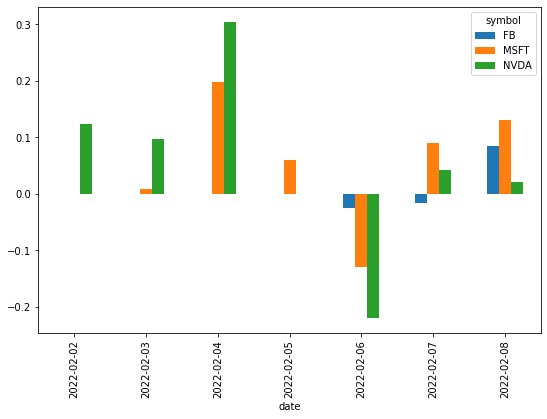

In [ ]:
# We will group the data frame on the symbol and date of each row, and then visualize  
# the average compound score for each day. We take the cross section of the 'compound' 
# rows, flip the data frame so that we have the dates on the x-axis and then plot it 
# as a Bar chart.
                                       
plt.rcParams['figure.figsize'] = [9, 6]
news_mean = news.groupby(['symbol', 'date']).mean().unstack()
news_mean = news_mean.xs('compound', axis="columns").transpose()
news_mean.plot(kind='bar')
plt.show()



**Compare Sentiments to Price Variances**

Let's now look at the sentiment scores and compare them to the price variances (difference between close price and open price) for each day. Recall that compound scores are computed by normalizing negative, neutral and positive scores. The price variances represent the dollar gain or loss for the day. We will select Nvidia stock prices for this analysis. We will ignore 2/5/2022 and 2/6/2022 dates because these are Saturday and Sunday when markets are closed.  

In [ ]:
# We will use the Yahoo! Finance Market Downloader to get the data for Nvidia stock.
# Install yfinance.
!pip install yfinance
import yfinance as yf

In [ ]:
# Get data for Nvidia corporation. 
nvidia = yf.download('NVDA',start='2022-02-02',  end='2022-02-09',progress=False)[['Open', 'Close', 'Volume']]
nvidia.reset_index(inplace=True)

In [ ]:
nvidia.head(7)

,Date,Open,Close,Volume
0,2022-02-02,257.940002,252.419998,54341900
1,2022-02-03,244.580002,239.479996,41017800
2,2022-02-04,239.720001,243.190002,35432800
3,2022-02-07,243.720001,247.279999,37686800
4,2022-02-08,243.589996,251.080002,40901100


In [ ]:
# Create a new variable for variance that contains the difference between the 
# close price and open price for each day.
nvidia['Variance'] = nvidia['Close'] - nvidia['Open']

# Create a new variable for compound and load the compound scoures for each day.
compound = ['0.12', '0.10', '0.30', '0.04', '0.02']
nvidia['Compound'] = compound

In [ ]:
nvidia.head(5)

,Date,Open,Close,Volume,Variance,Compound
0,2022-02-02,257.940002,252.419998,54341900,-5.520004,0.12
1,2022-02-03,244.580002,239.479996,41017800,-5.100006,0.10
2,2022-02-04,239.720001,243.190002,35432800,3.470001,0.30
3,2022-02-07,243.720001,247.279999,37686800,3.559998,0.04
4,2022-02-08,243.589996,251.080002,41035900,7.490005,0.02


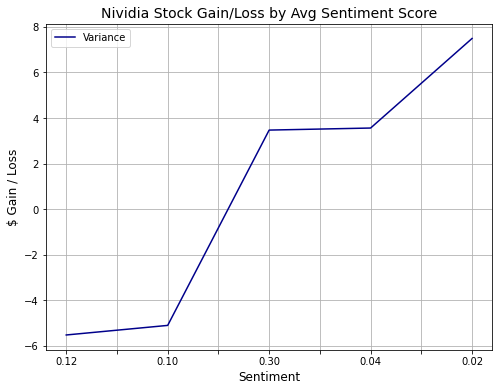

In [ ]:
# Plot $ gain/loss in stock price by average sentiment score. Each sentiment score 
# represents one trading day.  
plt.rcParams['figure.figsize'] = [8, 6]
 
nvidia.plot('Compound','Variance', color="darkblue")
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('$ Gain / Loss', fontsize=12)
plt.title('Nvidia Stock Gain/Loss by Avg Sentiment Score', fontsize=14)
plt.grid()
plt.show()

Observations:

* When average sentiment scores are slightly positive (0.12, 0.10), there was a loss of a little over $5.00.

* When average sentiment score was moderately positive (0.30), there was a gain of $3.47.

* When average sentiment score was barely positive (0.04), there was a gain of a $3.55.  

* When average sentiment score was barely positive (0.02), there was a gain of a $7.49.  



Conclusions:                                                                  For Nvidia, results were inconsistent when comparing average sentiment scores with stock price gain/loss on a daily bases. When sentiment scores were slightly positive, there was a loss. When sentiment score was moderately positive there was a gain. When sentiment scores were barely positive there were sizable gains. I think much more research is needed to better understand the relationship between sentiments and stock prices.                   